In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import os
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from manual_review_classifier.ClassifierPlots import create_reliability_diagram

sns.set_style("white")
sns.set_context('notebook')

Using TensorFlow backend.


In [3]:
training_data = pd.read_pickle('../data/training_data.pkl')

In [4]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [5]:
# Get Labels
Y = pd.get_dummies(training_data.call).astype(float).values
# Get training data as numpy array
X = training_data.drop('call', axis=1).astype(float).values

In [6]:
X.shape

(41654, 71)

In [7]:
Y.shape

(41654, 4)

In [8]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [9]:
# define baseline model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(4, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [10]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=10, batch_size=5, verbose=1)

In [11]:
kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [12]:
probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
if not os.path.exists('../data/log_reg/multiclass_probs.npy'):
    probabilities = cross_val_predict(estimator, X, Y, cv=kfold, method='predict_proba')
    np.save('../data/log_reg/multiclass_probs.npy', probabilities)
else:
    probabilities = np.load('../data/log_reg/multiclass_probs.npy')

Epoch 1/10
37488/37488 [==============================] - 22s - loss: 0.8308 - acc: 0.6462    
Epoch 2/10
37488/37488 [==============================] - 20s - loss: 0.7195 - acc: 0.7265    
Epoch 3/10
37488/37488 [==============================] - 20s - loss: 0.6932 - acc: 0.7338    
Epoch 4/10
37488/37488 [==============================] - 23s - loss: 0.6806 - acc: 0.7371    
Epoch 5/10
37488/37488 [==============================] - 23s - loss: 0.6727 - acc: 0.7393    
Epoch 6/10
37488/37488 [==============================] - 22s - loss: 0.6673 - acc: 0.7411    
Epoch 7/10
37488/37488 [==============================] - 24s - loss: 0.6624 - acc: 0.7441    
Epoch 8/10
37488/37488 [==============================] - 24s - loss: 0.6581 - acc: 0.7450    
Epoch 9/10
37488/37488 [==============================] - 24s - loss: 0.6541 - acc: 0.7473    
Epoch 10/10
37488/37488 [==============================] - 25s - loss: 0.8288 - acc: 0.6461    
Epoch 2/10
37488/37488 [=========================

37489/37489 [==============================] - ETA: 0s - loss: 0.7184 - acc: 0.726 - 22s - loss: 0.7185 - acc: 0.7258    
Epoch 3/10
37489/37489 [==============================] - 19s - loss: 0.6919 - acc: 0.7357    
Epoch 4/10
37489/37489 [==============================] - 18s - loss: 0.6785 - acc: 0.7396    
Epoch 5/10
37489/37489 [==============================] - 18s - loss: 0.6708 - acc: 0.7423    
Epoch 6/10
37489/37489 [==============================] - 18s - loss: 0.6647 - acc: 0.7444    
Epoch 7/10
37489/37489 [==============================] - 18s - loss: 0.6600 - acc: 0.7446    
Epoch 8/10
37489/37489 [==============================] - 17s - loss: 0.6558 - acc: 0.7464    
Epoch 9/10
37489/37489 [==============================] - 18s - loss: 0.6517 - acc: 0.7469    
Epoch 10/10
37489/37489 [==============================] - 18s - loss: 0.8308 - acc: 0.6408    
Epoch 2/10
37489/37489 [==============================] - 26s - loss: 0.7196 - acc: 0.7239    
Epoch 3/10
37489/37489

NameError: name 'os' is not defined

In [14]:
predicted = np.array([list(a).index(max(list(a))) for a in list(probabilities)])

In [15]:
label_binarizer = preprocessing.LabelBinarizer()

label_binarizer.fit(range(max(predicted)+1))
predicted_transformed = label_binarizer.transform(predicted)

In [16]:
metrics.accuracy_score(Y, predicted_transformed)

0.74797138330052337

#### Classification report
* 0 = ambiguous
* 1 = fail
* 2 = germline
* 3 = somatic

In [17]:
print(metrics.classification_report(Y, predicted_transformed))

             precision    recall  f1-score   support

          0       0.71      0.70      0.71     14589
          1       0.49      0.18      0.26      1600
          2       0.63      0.63      0.63      4309
          3       0.80      0.85      0.82     21156

avg / total       0.74      0.75      0.74     41654



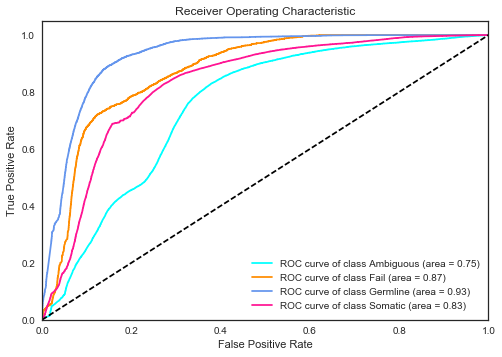

In [18]:
n_classes = Y.shape[1]
class_lookup = {0: 'Ambiguous', 1: 'Fail', 2: 'Germline', 3: 'Somatic'}
fpr = dict()
tpr = dict()
roc_auc = dict()
plt.title('Receiver Operating Characteristic')
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
for i, color in zip(range(n_classes), colors):
    fpr[i], tpr[i], _ = metrics.roc_curve(Y[:, i], probabilities[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, label='ROC curve of class {0}'
             ' (area = {1:0.2f})'.format(class_lookup[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00089957  0.0035822   0.00459466  0.00629871  0.00845529  0.00863959
  0.01109931  0.01290466  0.01475754  0.01565947]


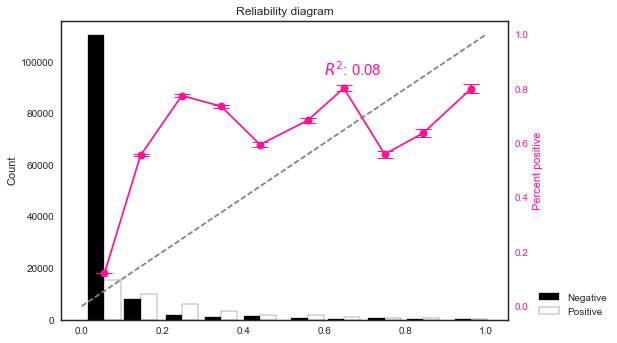

In [19]:
create_reliability_diagram(probabilities, Y, 
                           ['Ambiguous','Fail','Germline', 'Somatic'], 'deeppink')

## Refactor to single class classifier 
Manual reviewer's calling variants germline is problematic as the callers that produced the calls are designed to call somatic variants. These germline calls are likely very poor quality and in most analysis streams get thrown out anyway. While 'ambigous' variant exist in a grey area where the reviewer is unsure whether to call the variant somatic or fail. All of these classes (germile, ambiguous, and fail) are treated the same in downstream analysis (thrown out).

In [20]:
training_data.groupby('call').size()

call
a    14589
f     1600
g     4309
s    21156
dtype: int64

In [21]:
training_data['binary_call'] = training_data.call.replace(['a', 'f', 'g'], False)
training_data['binary_call'] = training_data['binary_call'].replace('s', True)

In [22]:
training_data.groupby('binary_call').size()

binary_call
False    20498
True     21156
dtype: int64

In [23]:
# Get Labels
binary_Y = training_data.binary_call.astype(int).values
# Get training data as numpy array
X = training_data.drop(['call', 'binary_call'], axis=1).astype(float).values

In [24]:
X.shape

(41654, 71)

In [25]:
binary_Y.shape

(41654,)

In [26]:
# define baseline model
def baseline_binary_model():
    # create model
    model = Sequential()
    model.add(Dense(2, input_dim=71, kernel_initializer='normal', activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
binary_estimator = KerasClassifier(build_fn=baseline_binary_model, epochs=10, batch_size=5, verbose=1)

In [28]:
binary_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

In [29]:
if not os.path.exists('../data/log_reg/binary_probs.npy'):
    binary_probabilities = cross_val_predict(binary_estimator, X, binary_Y, cv=binary_kfold, method='predict_proba')
    np.save('../data/log_reg/binary_probs.npy', probabilities)
else:
    binary_probabilities = np.load('../data/log_reg/binary_probs.npy')

Epoch 1/10
37488/37488 [==============================] - 23s - loss: 0.5413 - acc: 0.7304    
Epoch 2/10
37488/37488 [==============================] - 20s - loss: 0.4739 - acc: 0.8042    
Epoch 3/10
37488/37488 [==============================] - 22s - loss: 0.4585 - acc: 0.8163    
Epoch 4/10
37488/37488 [==============================] - 23s - loss: 0.4515 - acc: 0.8184    
Epoch 5/10
37488/37488 [==============================] - 17s - loss: 0.4468 - acc: 0.8208    
Epoch 6/10
37488/37488 [==============================] - 17s - loss: 0.4436 - acc: 0.8228    
Epoch 7/10
37488/37488 [==============================] - 18s - loss: 0.4402 - acc: 0.8224    
Epoch 8/10
37488/37488 [==============================] - 17s - loss: 0.4369 - acc: 0.8246    
Epoch 9/10
37488/37488 [==============================] - 18s - loss: 0.4340 - acc: 0.8252    
Epoch 10/10
37488/37488 [==============================] - 17s - loss: 0.5427 - acc: 0.7306    
Epoch 2/10
37488/37488 [=========================

37489/37489 [==============================] - 21s - loss: 0.4721 - acc: 0.8071    
Epoch 3/10
37489/37489 [==============================] - 23s - loss: 0.4567 - acc: 0.8173    
Epoch 4/10
37489/37489 [==============================] - 20s - loss: 0.4491 - acc: 0.8208    
Epoch 5/10
37489/37489 [==============================] - 21s - loss: 0.4445 - acc: 0.8229    
Epoch 6/10
37489/37489 [==============================] - 25s - loss: 0.4409 - acc: 0.8243    
Epoch 7/10
37489/37489 [==============================] - 22s - loss: 0.4372 - acc: 0.8251    
Epoch 8/10
37489/37489 [==============================] - 23s - loss: 0.4340 - acc: 0.8263    
Epoch 9/10
37489/37489 [==============================] - 17s - loss: 0.4304 - acc: 0.8272    
Epoch 10/10
37489/37489 [==============================] - 21s - loss: 0.5439 - acc: 0.7272    
Epoch 2/10
37489/37489 [==============================] - 19s - loss: 0.4740 - acc: 0.8052    
Epoch 3/10
37489/37489 [==============================] - 27

In [30]:
binary_probabilities

array([[  5.22742987e-01,   2.11707413e-01],
       [  3.63412872e-02,   8.91072035e-01],
       [  3.32534015e-02,   7.09695339e-01],
       ..., 
       [  1.07334303e-02,   6.62329018e-01],
       [  8.24065600e-03,   8.46966922e-01],
       [  9.83888090e-01,   8.61778855e-04]], dtype=float32)

In [31]:
predicted = np.array([list(a).index(max(list(a))) for a in list(binary_probabilities)])

In [32]:
metrics.accuracy_score(binary_Y, predicted)

0.82738752580784558

In [33]:
print(metrics.classification_report(binary_Y, predicted))

             precision    recall  f1-score   support

          0       0.82      0.83      0.83     20498
          1       0.83      0.82      0.83     21156

avg / total       0.83      0.83      0.83     41654



In [34]:
somatic_prob = binary_probabilities[:,1]

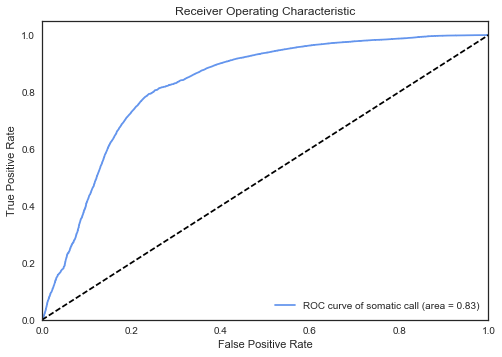

In [35]:
plt.title('Receiver Operating Characteristic')
fpr, tpr, _ = metrics.roc_curve(binary_Y, somatic_prob)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='cornflowerblue',label='ROC curve of somatic call'
         ' (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

confidence intervals +-:  [ 0.00206313  0.00359279  0.00426572  0.0048848   0.00707805  0.00833114
  0.00880318  0.00637868  0.00822429  0.00739776]


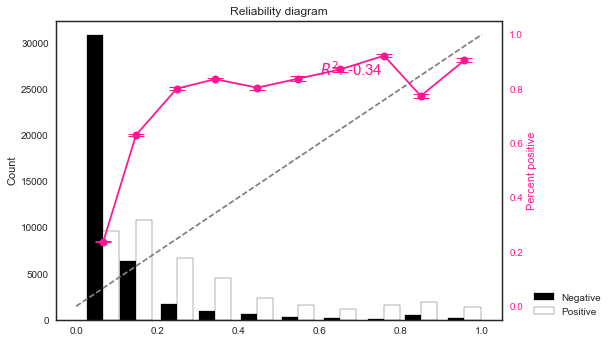

In [36]:
create_reliability_diagram(binary_probabilities, np.array([np.logical_not(binary_Y),binary_Y]).T,['Fail', 'Somatic'], 'deeppink')